# Fachprojekt Machine Learning
**Authors:** Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 3. July 2024

## Import necessary components

In [4]:
# Import the necessary libraries
import time, warnings, random
import torch, torch.nn.functional as F
from tabulate import tabulate
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the VAE model and functions
import networks
from datasets import create_datasets
from evaluation import evaluate
from interpolation import interpolate
from sampling import plot_reconstruction
from plotting import plot_loss_lr, plot_loss_components

## Set hyperparameters, loss function and optimizing tools

In [5]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 30 # One epoch means seeing every image of the training dataset
input_channels = 3  # CIFAR-10 images have 3 color channels
learning_rate = 2e-5 # Determines how drastically the parameters of the network change
output_frequency = 150 # Determines how often the training progress will be logged (in batches)
number_embedding_vectors = 100 # Size of the codebook
embedding_dimension = 128 # Dimensionality of each embedding vector in the codebook
beta = 0.1 # Balances the influence of the commitment loss relative to the reconstruction and codebook losses

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VQVAE(input_channels=input_channels, emb_dim=embedding_dimension, n_embed=number_embedding_vectors, beta=beta)
model.to(device)

# Loss function
def loss_function(recon_x, x, vq_loss):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss + vq_loss, recon_loss, vq_loss

# Optimizer selection
optimizer_option = 'adam'

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'exponential'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


## Choose a dataset for training

100%|██████████| 170498071/170498071 [00:13<00:00, 13091358.87it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


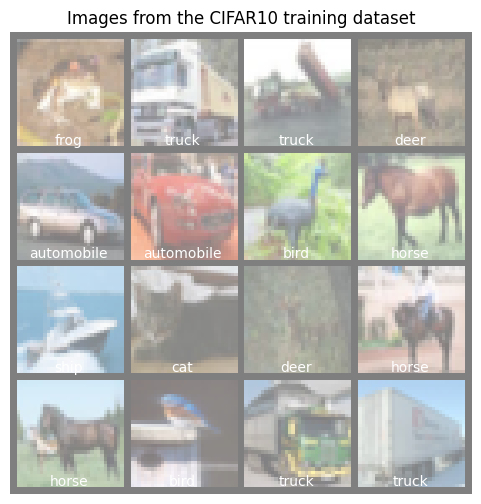

In [3]:
# Create and visualize the datasets for MNIST / CIFAR10 / CelebA
dataset_name = 'CIFAR10'
train_loader, test_loader = create_datasets(dataset_name, batch_size)

## Training loop

-----------------------------------------------------------------------------------------------------------------------------
Epoch:  1/ 30  Batch:    1  Total Loss:  51102.2  VQ Loss:  0.788299  Recon Loss:  51101.4  Commitment Loss:  0.716635  Embedding Loss:  0.716635  LR:  2e-05
Epoch:  1/ 30  Batch:  151  Total Loss:  5699.39  VQ Loss:  1.54322  Recon Loss:  5697.85  Commitment Loss:  1.40293  Embedding Loss:  1.40293  LR:  2e-05
Epoch:  1/ 30  Batch:  301  Total Loss:  3511.68  VQ Loss:  1.6369  Recon Loss:  3510.04  Commitment Loss:  1.48809  Embedding Loss:  1.48809  LR:  2e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       1 │          5635.92 │ 9.70s  │
╘═════════╧══════════════════╧════════╛


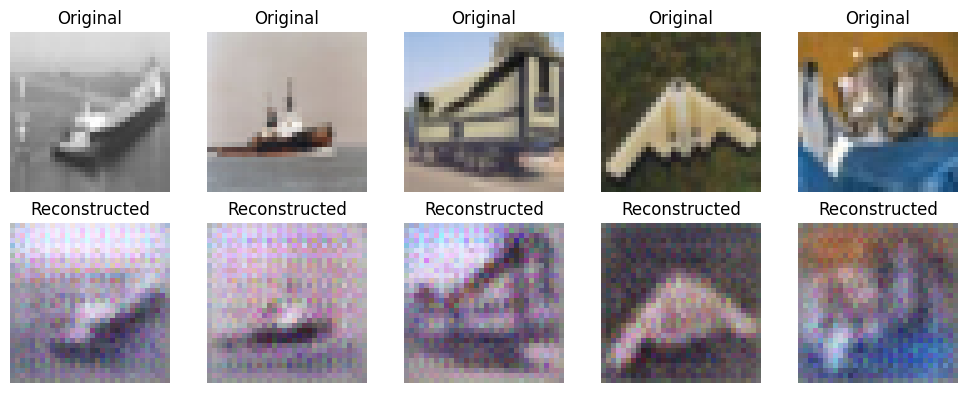

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  2/ 30  Batch:    1  Total Loss:  2932.63  VQ Loss:  1.65297  Recon Loss:  2930.98  Commitment Loss:  1.5027  Embedding Loss:  1.5027  LR:  1.8e-05
Epoch:  2/ 30  Batch:  151  Total Loss:  2192.29  VQ Loss:  1.74419  Recon Loss:  2190.55  Commitment Loss:  1.58563  Embedding Loss:  1.58563  LR:  1.8e-05
Epoch:  2/ 30  Batch:  301  Total Loss:  1979.61  VQ Loss:  1.75692  Recon Loss:  1977.86  Commitment Loss:  1.5972  Embedding Loss:  1.5972  LR:  1.8e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       2 │          3920.91 │ 6.94s  │
╘═════════╧══════════════════╧════════╛


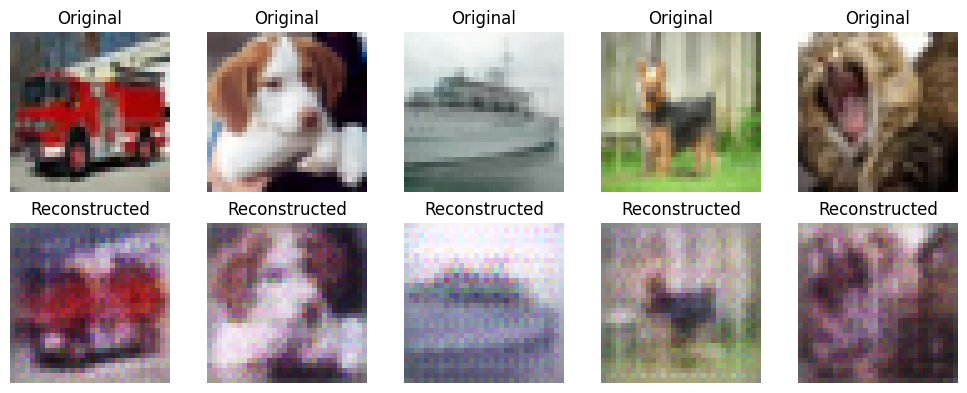

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  3/ 30  Batch:    1  Total Loss:  1899.57  VQ Loss:  1.7831  Recon Loss:  1897.79  Commitment Loss:  1.621  Embedding Loss:  1.621  LR:  1.62e-05
Epoch:  3/ 30  Batch:  151  Total Loss:  1725.63  VQ Loss:  1.73737  Recon Loss:  1723.89  Commitment Loss:  1.57943  Embedding Loss:  1.57943  LR:  1.62e-05
Epoch:  3/ 30  Batch:  301  Total Loss:  1405.36  VQ Loss:  1.84986  Recon Loss:  1403.51  Commitment Loss:  1.68169  Embedding Loss:  1.68169  LR:  1.62e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       3 │          3299.97 │ 7.00s  │
╘═════════╧══════════════════╧════════╛


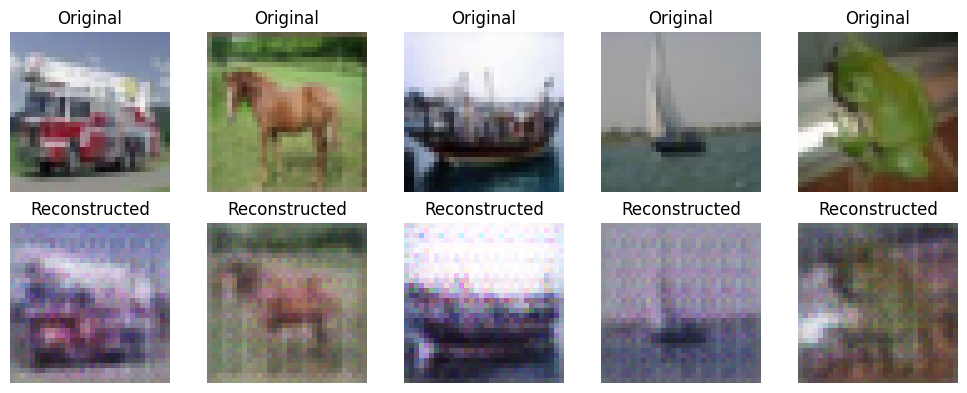

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  4/ 30  Batch:    1  Total Loss:  1537.91  VQ Loss:  1.93802  Recon Loss:  1535.97  Commitment Loss:  1.76183  Embedding Loss:  1.76183  LR:  1.458e-05
Epoch:  4/ 30  Batch:  151  Total Loss:  1378.06  VQ Loss:  1.90314  Recon Loss:  1376.16  Commitment Loss:  1.73012  Embedding Loss:  1.73012  LR:  1.458e-05
Epoch:  4/ 30  Batch:  301  Total Loss:  1230.23  VQ Loss:  1.78461  Recon Loss:  1228.45  Commitment Loss:  1.62237  Embedding Loss:  1.62237  LR:  1.458e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       4 │          2739.81 │ 6.85s  │
╘═════════╧══════════════════╧════════╛


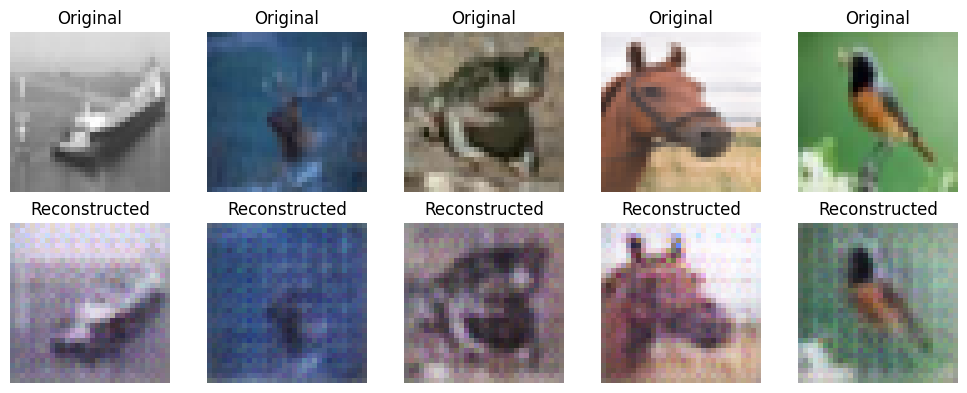

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  5/ 30  Batch:    1  Total Loss:  1263.77  VQ Loss:  1.82601  Recon Loss:  1261.95  Commitment Loss:  1.66001  Embedding Loss:  1.66001  LR:  1.3122e-05
Epoch:  5/ 30  Batch:  151  Total Loss:  1130.72  VQ Loss:  1.85846  Recon Loss:  1128.86  Commitment Loss:  1.68951  Embedding Loss:  1.68951  LR:  1.3122e-05
Epoch:  5/ 30  Batch:  301  Total Loss:  1160.74  VQ Loss:  1.90029  Recon Loss:  1158.84  Commitment Loss:  1.72754  Embedding Loss:  1.72754  LR:  1.3122e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       5 │          2543.28 │ 7.04s  │
╘═════════╧══════════════════╧════════╛


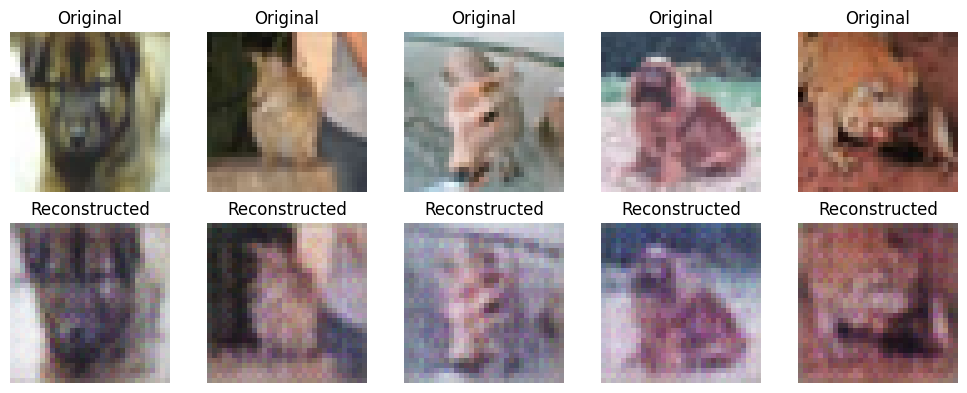

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  6/ 30  Batch:    1  Total Loss:  1193.77  VQ Loss:  1.82788  Recon Loss:  1191.94  Commitment Loss:  1.66171  Embedding Loss:  1.66171  LR:  1.18098e-05
Epoch:  6/ 30  Batch:  151  Total Loss:  1169.34  VQ Loss:  1.86038  Recon Loss:  1167.48  Commitment Loss:  1.69126  Embedding Loss:  1.69126  LR:  1.18098e-05
Epoch:  6/ 30  Batch:  301  Total Loss:  1158.88  VQ Loss:  1.82707  Recon Loss:  1157.05  Commitment Loss:  1.66097  Embedding Loss:  1.66097  LR:  1.18098e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       6 │          2371.81 │ 7.17s  │
╘═════════╧══════════════════╧════════╛


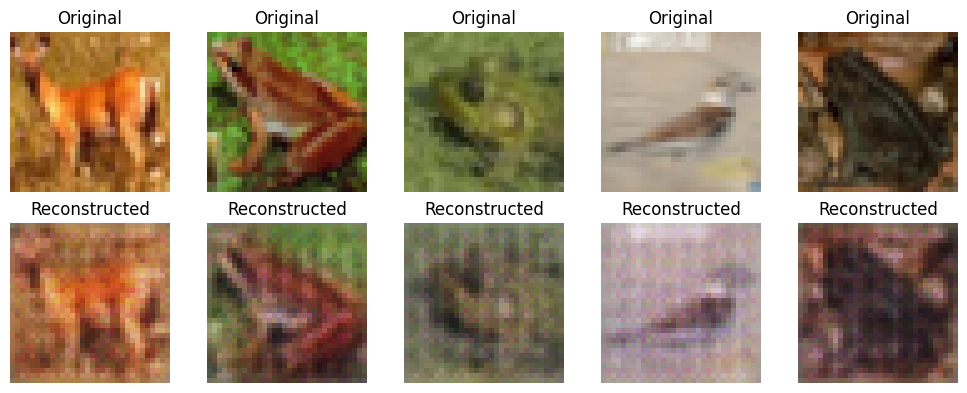

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  7/ 30  Batch:    1  Total Loss:  977.594  VQ Loss:  1.93536  Recon Loss:  975.659  Commitment Loss:  1.75941  Embedding Loss:  1.75941  LR:  1.06288e-05
Epoch:  7/ 30  Batch:  151  Total Loss:  962.867  VQ Loss:  1.86633  Recon Loss:  961.001  Commitment Loss:  1.69667  Embedding Loss:  1.69667  LR:  1.06288e-05
Epoch:  7/ 30  Batch:  301  Total Loss:  947.799  VQ Loss:  1.85775  Recon Loss:  945.942  Commitment Loss:  1.68887  Embedding Loss:  1.68887  LR:  1.06288e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       7 │          2248.88 │ 7.04s  │
╘═════════╧══════════════════╧════════╛


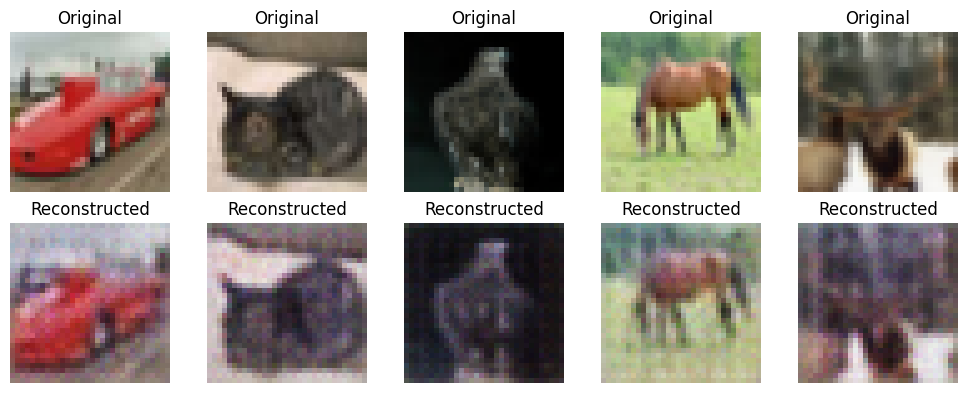

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  8/ 30  Batch:    1  Total Loss:  949.749  VQ Loss:  1.94066  Recon Loss:  947.808  Commitment Loss:  1.76424  Embedding Loss:  1.76424  LR:  9.56594e-06
Epoch:  8/ 30  Batch:  151  Total Loss:  1135.58  VQ Loss:  1.76461  Recon Loss:  1133.81  Commitment Loss:  1.60419  Embedding Loss:  1.60419  LR:  9.56594e-06
Epoch:  8/ 30  Batch:  301  Total Loss:  875.791  VQ Loss:  1.87825  Recon Loss:  873.913  Commitment Loss:  1.7075  Embedding Loss:  1.7075  LR:  9.56594e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       8 │          2125.16 │ 7.06s  │
╘═════════╧══════════════════╧════════╛


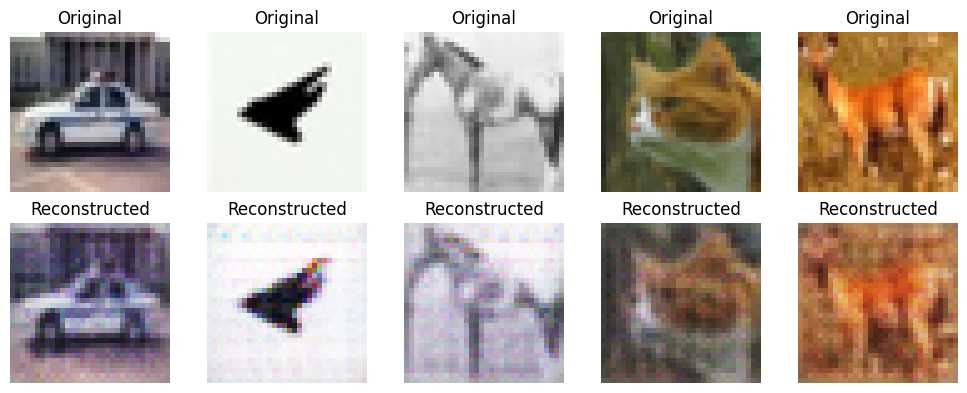

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  9/ 30  Batch:    1  Total Loss:  882.014  VQ Loss:  1.87489  Recon Loss:  880.139  Commitment Loss:  1.70444  Embedding Loss:  1.70444  LR:  8.60934e-06
Epoch:  9/ 30  Batch:  151  Total Loss:  837.885  VQ Loss:  1.84953  Recon Loss:  836.036  Commitment Loss:  1.68139  Embedding Loss:  1.68139  LR:  8.60934e-06
Epoch:  9/ 30  Batch:  301  Total Loss:  863.027  VQ Loss:  1.84746  Recon Loss:  861.18  Commitment Loss:  1.67951  Embedding Loss:  1.67951  LR:  8.60934e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       9 │           1936.6 │ 6.72s  │
╘═════════╧══════════════════╧════════╛


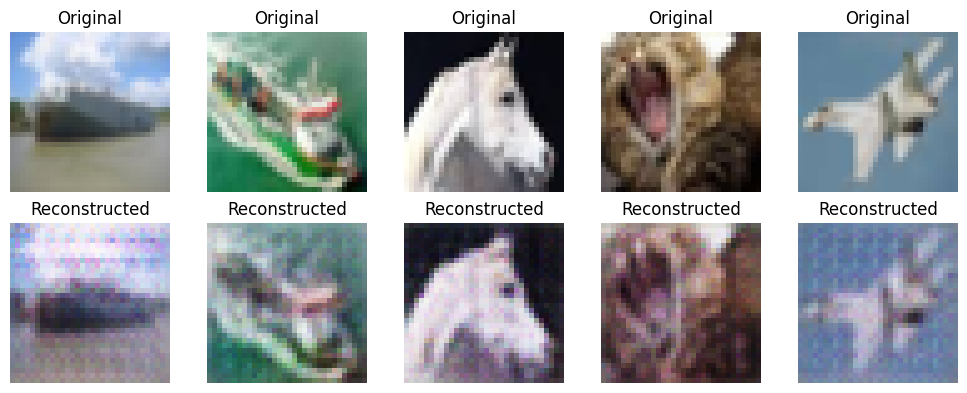

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  10/ 30  Batch:    1  Total Loss:  827.918  VQ Loss:  1.84363  Recon Loss:  826.074  Commitment Loss:  1.67603  Embedding Loss:  1.67603  LR:  7.74841e-06
Epoch:  10/ 30  Batch:  151  Total Loss:  868.938  VQ Loss:  1.83539  Recon Loss:  867.103  Commitment Loss:  1.66854  Embedding Loss:  1.66854  LR:  7.74841e-06
Epoch:  10/ 30  Batch:  301  Total Loss:  773.931  VQ Loss:  1.84494  Recon Loss:  772.086  Commitment Loss:  1.67722  Embedding Loss:  1.67722  LR:  7.74841e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      10 │          2048.57 │ 6.92s  │
╘═════════╧══════════════════╧════════╛


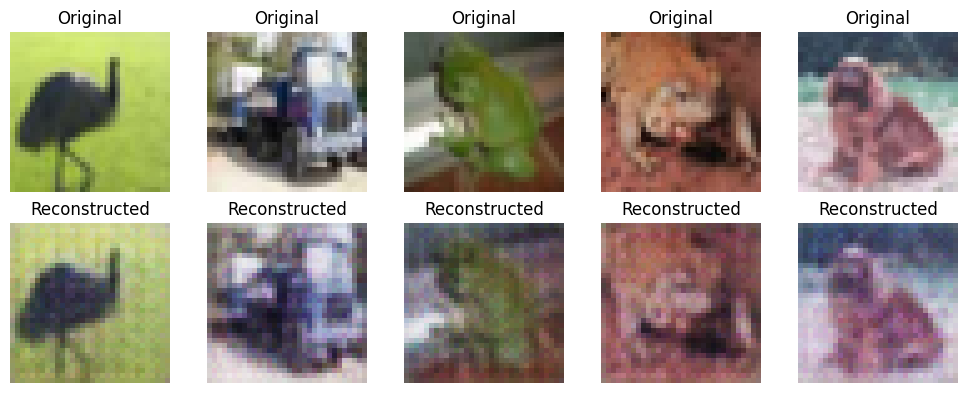

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  11/ 30  Batch:    1  Total Loss:  744.769  VQ Loss:  1.89277  Recon Loss:  742.876  Commitment Loss:  1.7207  Embedding Loss:  1.7207  LR:  6.97357e-06
Epoch:  11/ 30  Batch:  151  Total Loss:  725.405  VQ Loss:  1.88024  Recon Loss:  723.525  Commitment Loss:  1.70931  Embedding Loss:  1.70931  LR:  6.97357e-06
Epoch:  11/ 30  Batch:  301  Total Loss:  733.894  VQ Loss:  1.84392  Recon Loss:  732.05  Commitment Loss:  1.67629  Embedding Loss:  1.67629  LR:  6.97357e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      11 │          1841.28 │ 7.05s  │
╘═════════╧══════════════════╧════════╛


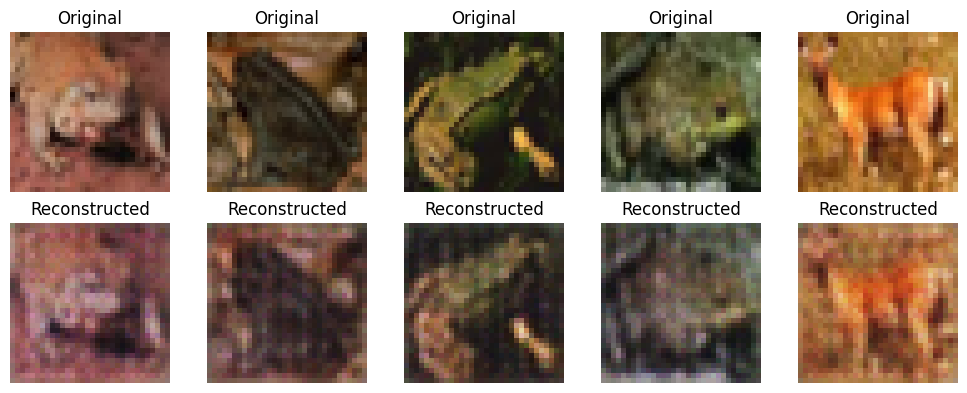

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  12/ 30  Batch:    1  Total Loss:  713.374  VQ Loss:  1.8611  Recon Loss:  711.513  Commitment Loss:  1.69191  Embedding Loss:  1.69191  LR:  6.27621e-06
Epoch:  12/ 30  Batch:  151  Total Loss:  830.956  VQ Loss:  1.79881  Recon Loss:  829.157  Commitment Loss:  1.63528  Embedding Loss:  1.63528  LR:  6.27621e-06
Epoch:  12/ 30  Batch:  301  Total Loss:  689.96  VQ Loss:  1.86858  Recon Loss:  688.092  Commitment Loss:  1.69871  Embedding Loss:  1.69871  LR:  6.27621e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      12 │          1832.08 │ 6.92s  │
╘═════════╧══════════════════╧════════╛


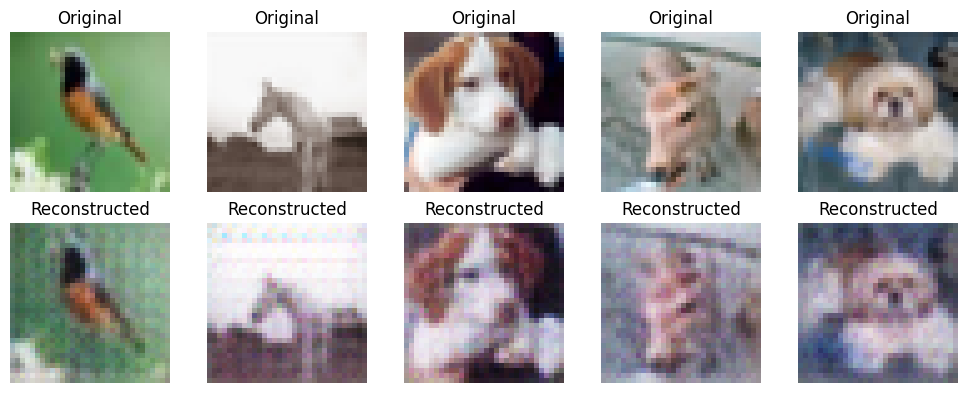

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  13/ 30  Batch:    1  Total Loss:  731.961  VQ Loss:  1.84243  Recon Loss:  730.119  Commitment Loss:  1.67494  Embedding Loss:  1.67494  LR:  5.64859e-06
Epoch:  13/ 30  Batch:  151  Total Loss:  637.229  VQ Loss:  1.83388  Recon Loss:  635.395  Commitment Loss:  1.66717  Embedding Loss:  1.66717  LR:  5.64859e-06
Epoch:  13/ 30  Batch:  301  Total Loss:  708.733  VQ Loss:  1.82417  Recon Loss:  706.909  Commitment Loss:  1.65834  Embedding Loss:  1.65834  LR:  5.64859e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      13 │          1819.36 │ 6.86s  │
╘═════════╧══════════════════╧════════╛


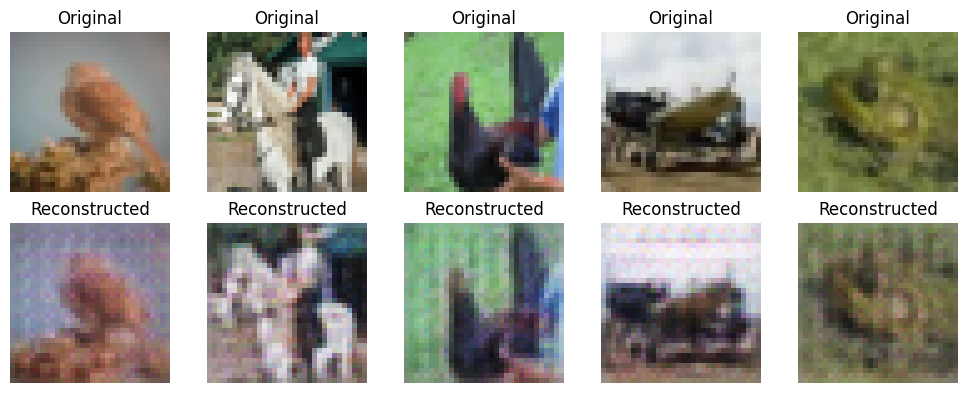

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  14/ 30  Batch:    1  Total Loss:  826.753  VQ Loss:  1.86075  Recon Loss:  824.892  Commitment Loss:  1.69159  Embedding Loss:  1.69159  LR:  5.08373e-06
Epoch:  14/ 30  Batch:  151  Total Loss:  860.637  VQ Loss:  1.8801  Recon Loss:  858.757  Commitment Loss:  1.70918  Embedding Loss:  1.70918  LR:  5.08373e-06
Epoch:  14/ 30  Batch:  301  Total Loss:  663.83  VQ Loss:  1.82949  Recon Loss:  662  Commitment Loss:  1.66317  Embedding Loss:  1.66317  LR:  5.08373e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      14 │          1903.34 │ 7.01s  │
╘═════════╧══════════════════╧════════╛


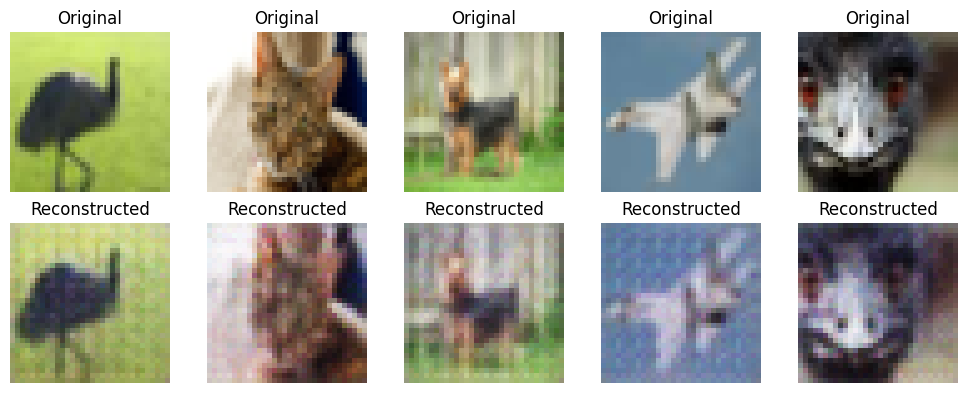

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  15/ 30  Batch:    1  Total Loss:  653.359  VQ Loss:  1.85107  Recon Loss:  651.508  Commitment Loss:  1.68279  Embedding Loss:  1.68279  LR:  4.57536e-06
Epoch:  15/ 30  Batch:  151  Total Loss:  700.736  VQ Loss:  1.864  Recon Loss:  698.872  Commitment Loss:  1.69455  Embedding Loss:  1.69455  LR:  4.57536e-06
Epoch:  15/ 30  Batch:  301  Total Loss:  725.734  VQ Loss:  1.75061  Recon Loss:  723.983  Commitment Loss:  1.59146  Embedding Loss:  1.59146  LR:  4.57536e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      15 │          1715.07 │ 7.03s  │
╘═════════╧══════════════════╧════════╛


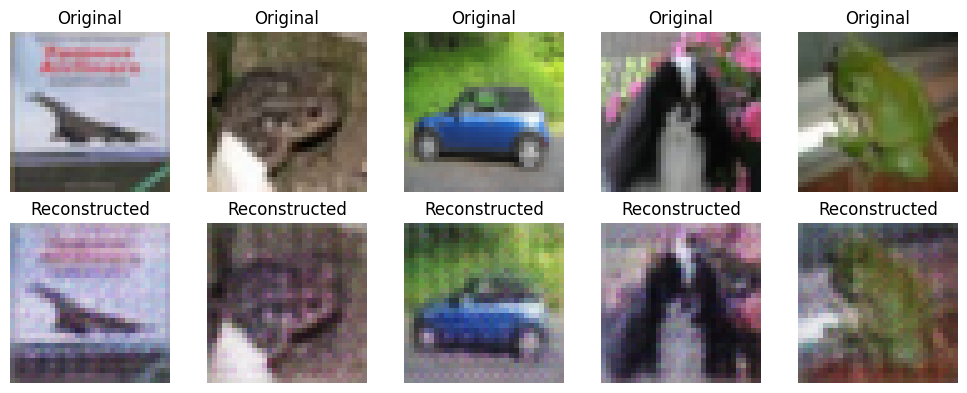

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  16/ 30  Batch:    1  Total Loss:  635.508  VQ Loss:  1.82853  Recon Loss:  633.68  Commitment Loss:  1.6623  Embedding Loss:  1.6623  LR:  4.11782e-06
Epoch:  16/ 30  Batch:  151  Total Loss:  650  VQ Loss:  1.85692  Recon Loss:  648.143  Commitment Loss:  1.68811  Embedding Loss:  1.68811  LR:  4.11782e-06
Epoch:  16/ 30  Batch:  301  Total Loss:  711.768  VQ Loss:  1.84581  Recon Loss:  709.922  Commitment Loss:  1.67801  Embedding Loss:  1.67801  LR:  4.11782e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      16 │          1762.87 │ 6.70s  │
╘═════════╧══════════════════╧════════╛


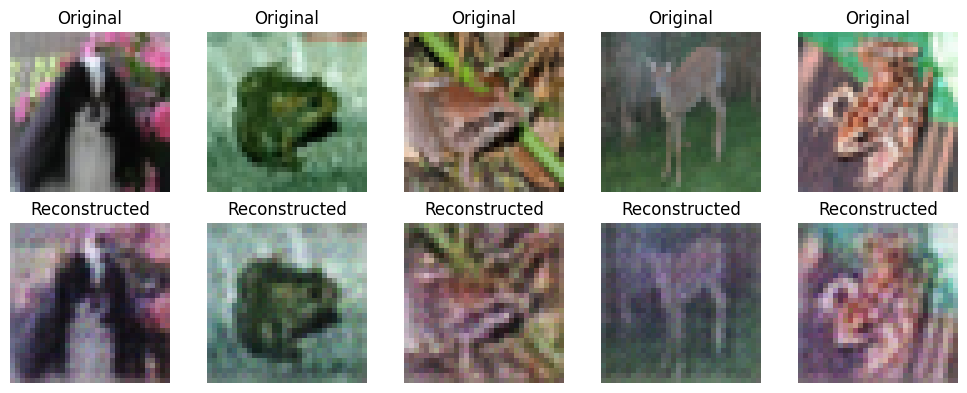

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  17/ 30  Batch:    1  Total Loss:  644.251  VQ Loss:  1.87228  Recon Loss:  642.379  Commitment Loss:  1.70208  Embedding Loss:  1.70208  LR:  3.70604e-06
Epoch:  17/ 30  Batch:  151  Total Loss:  673.49  VQ Loss:  1.81852  Recon Loss:  671.672  Commitment Loss:  1.6532  Embedding Loss:  1.6532  LR:  3.70604e-06
Epoch:  17/ 30  Batch:  301  Total Loss:  638.149  VQ Loss:  1.83997  Recon Loss:  636.309  Commitment Loss:  1.6727  Embedding Loss:  1.6727  LR:  3.70604e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      17 │          1701.18 │ 7.15s  │
╘═════════╧══════════════════╧════════╛


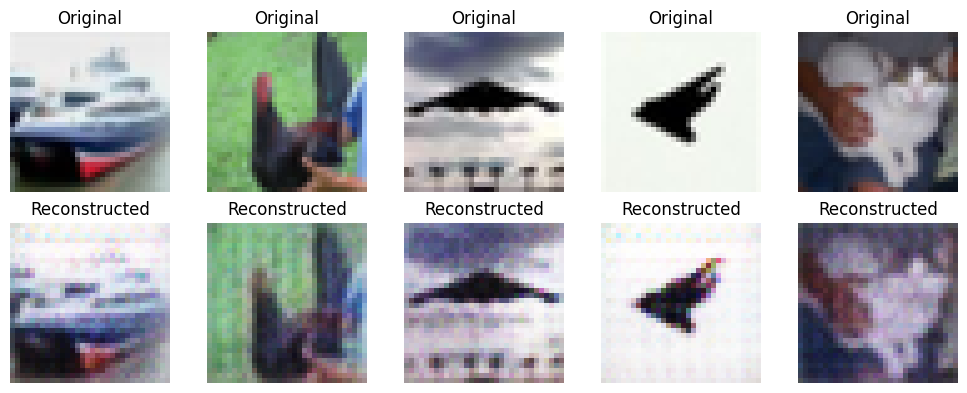

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  18/ 30  Batch:    1  Total Loss:  591.486  VQ Loss:  1.85941  Recon Loss:  589.626  Commitment Loss:  1.69037  Embedding Loss:  1.69037  LR:  3.33544e-06
Epoch:  18/ 30  Batch:  151  Total Loss:  605.014  VQ Loss:  1.81356  Recon Loss:  603.2  Commitment Loss:  1.64869  Embedding Loss:  1.64869  LR:  3.33544e-06
Epoch:  18/ 30  Batch:  301  Total Loss:  748.82  VQ Loss:  1.79188  Recon Loss:  747.029  Commitment Loss:  1.62898  Embedding Loss:  1.62898  LR:  3.33544e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      18 │          1692.42 │ 7.21s  │
╘═════════╧══════════════════╧════════╛


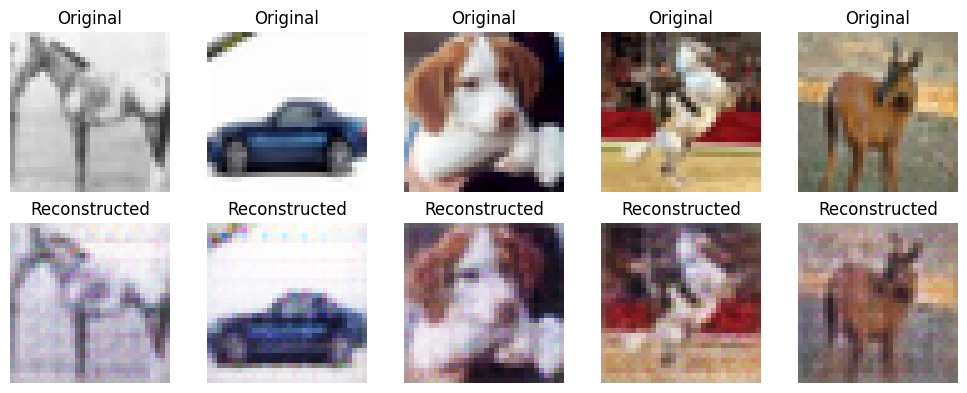

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  19/ 30  Batch:    1  Total Loss:  853.195  VQ Loss:  1.83233  Recon Loss:  851.363  Commitment Loss:  1.66576  Embedding Loss:  1.66576  LR:  3.00189e-06
Epoch:  19/ 30  Batch:  151  Total Loss:  765.871  VQ Loss:  1.86163  Recon Loss:  764.01  Commitment Loss:  1.69239  Embedding Loss:  1.69239  LR:  3.00189e-06
Epoch:  19/ 30  Batch:  301  Total Loss:  642.949  VQ Loss:  1.79866  Recon Loss:  641.15  Commitment Loss:  1.63515  Embedding Loss:  1.63515  LR:  3.00189e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      19 │          1761.76 │ 7.10s  │
╘═════════╧══════════════════╧════════╛


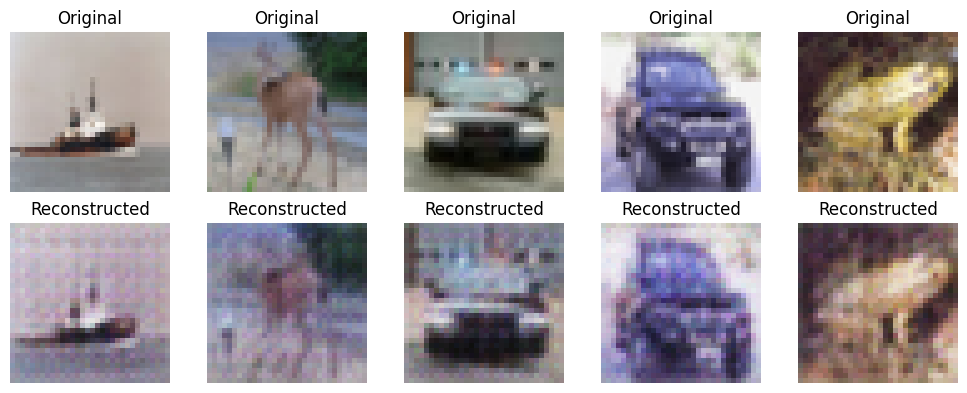

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  20/ 30  Batch:    1  Total Loss:  624.235  VQ Loss:  1.8362  Recon Loss:  622.399  Commitment Loss:  1.66927  Embedding Loss:  1.66927  LR:  2.7017e-06
Epoch:  20/ 30  Batch:  151  Total Loss:  559.226  VQ Loss:  1.84109  Recon Loss:  557.385  Commitment Loss:  1.67372  Embedding Loss:  1.67372  LR:  2.7017e-06
Epoch:  20/ 30  Batch:  301  Total Loss:  537.169  VQ Loss:  1.82855  Recon Loss:  535.34  Commitment Loss:  1.66232  Embedding Loss:  1.66232  LR:  2.7017e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      20 │          1675.64 │ 7.01s  │
╘═════════╧══════════════════╧════════╛


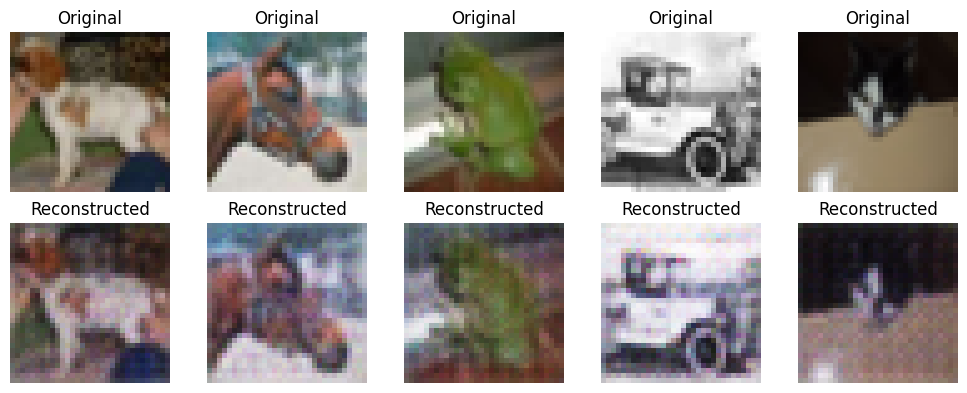

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  21/ 30  Batch:    1  Total Loss:  525.446  VQ Loss:  1.81649  Recon Loss:  523.63  Commitment Loss:  1.65136  Embedding Loss:  1.65136  LR:  2.43153e-06
Epoch:  21/ 30  Batch:  151  Total Loss:  638.154  VQ Loss:  1.82107  Recon Loss:  636.333  Commitment Loss:  1.65552  Embedding Loss:  1.65552  LR:  2.43153e-06
Epoch:  21/ 30  Batch:  301  Total Loss:  545.197  VQ Loss:  1.79892  Recon Loss:  543.398  Commitment Loss:  1.63539  Embedding Loss:  1.63539  LR:  2.43153e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      21 │          1650.69 │ 7.22s  │
╘═════════╧══════════════════╧════════╛


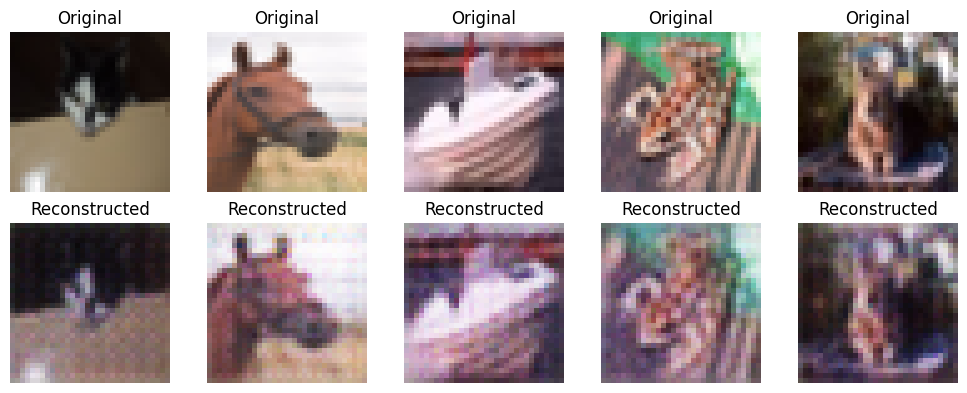

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  22/ 30  Batch:    1  Total Loss:  572.329  VQ Loss:  1.82908  Recon Loss:  570.5  Commitment Loss:  1.6628  Embedding Loss:  1.6628  LR:  2.18838e-06
Epoch:  22/ 30  Batch:  151  Total Loss:  566.237  VQ Loss:  1.82102  Recon Loss:  564.416  Commitment Loss:  1.65547  Embedding Loss:  1.65547  LR:  2.18838e-06
Epoch:  22/ 30  Batch:  301  Total Loss:  555.05  VQ Loss:  1.83772  Recon Loss:  553.212  Commitment Loss:  1.67066  Embedding Loss:  1.67066  LR:  2.18838e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      22 │          1670.96 │ 6.89s  │
╘═════════╧══════════════════╧════════╛


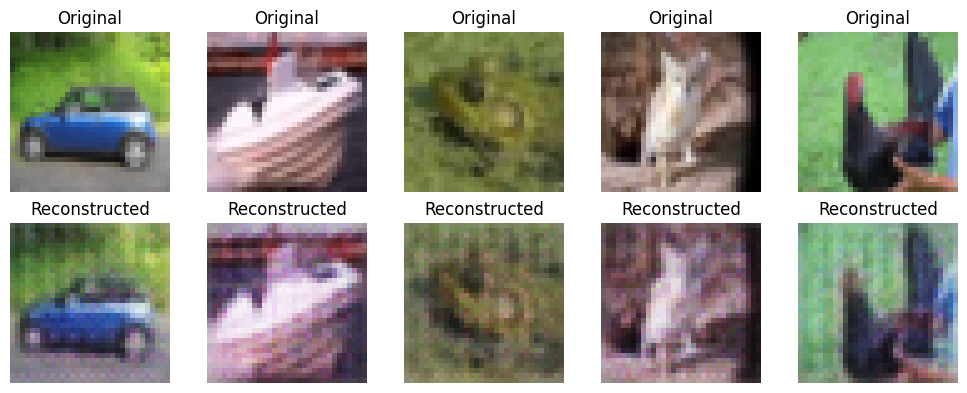

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  23/ 30  Batch:    1  Total Loss:  713.955  VQ Loss:  1.84872  Recon Loss:  712.107  Commitment Loss:  1.68065  Embedding Loss:  1.68065  LR:  1.96954e-06
Epoch:  23/ 30  Batch:  151  Total Loss:  628.597  VQ Loss:  1.83119  Recon Loss:  626.766  Commitment Loss:  1.66472  Embedding Loss:  1.66472  LR:  1.96954e-06
Epoch:  23/ 30  Batch:  301  Total Loss:  637.992  VQ Loss:  1.80163  Recon Loss:  636.191  Commitment Loss:  1.63784  Embedding Loss:  1.63784  LR:  1.96954e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      23 │          1698.16 │ 6.76s  │
╘═════════╧══════════════════╧════════╛


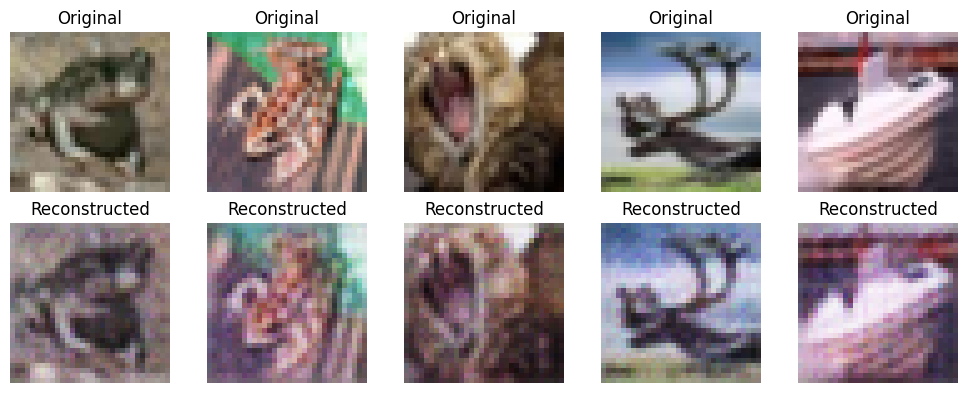

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  24/ 30  Batch:    1  Total Loss:  556.628  VQ Loss:  1.83726  Recon Loss:  554.791  Commitment Loss:  1.67024  Embedding Loss:  1.67024  LR:  1.77259e-06
Epoch:  24/ 30  Batch:  151  Total Loss:  541.132  VQ Loss:  1.82718  Recon Loss:  539.305  Commitment Loss:  1.66107  Embedding Loss:  1.66107  LR:  1.77259e-06
Epoch:  24/ 30  Batch:  301  Total Loss:  700.561  VQ Loss:  1.82817  Recon Loss:  698.733  Commitment Loss:  1.66197  Embedding Loss:  1.66197  LR:  1.77259e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      24 │          1611.47 │ 7.14s  │
╘═════════╧══════════════════╧════════╛


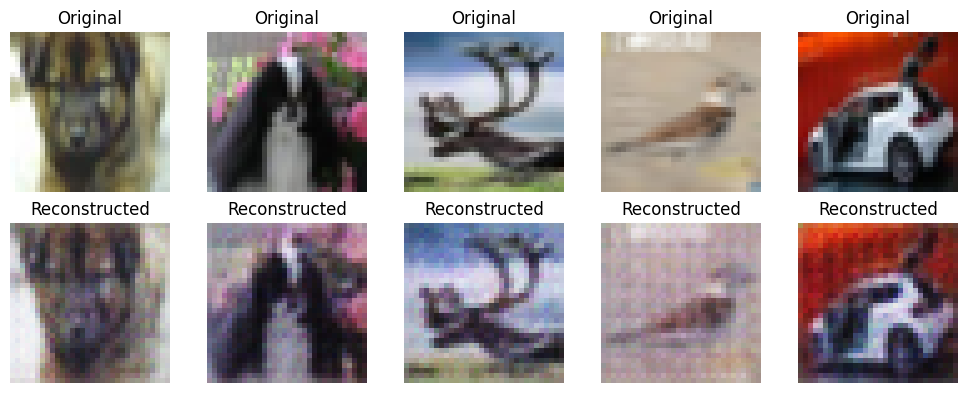

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  25/ 30  Batch:    1  Total Loss:  653.657  VQ Loss:  1.85619  Recon Loss:  651.801  Commitment Loss:  1.68745  Embedding Loss:  1.68745  LR:  1.59533e-06
Epoch:  25/ 30  Batch:  151  Total Loss:  597.482  VQ Loss:  1.80811  Recon Loss:  595.674  Commitment Loss:  1.64374  Embedding Loss:  1.64374  LR:  1.59533e-06
Epoch:  25/ 30  Batch:  301  Total Loss:  711.965  VQ Loss:  1.77555  Recon Loss:  710.189  Commitment Loss:  1.61413  Embedding Loss:  1.61413  LR:  1.59533e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      25 │           1706.1 │ 7.16s  │
╘═════════╧══════════════════╧════════╛


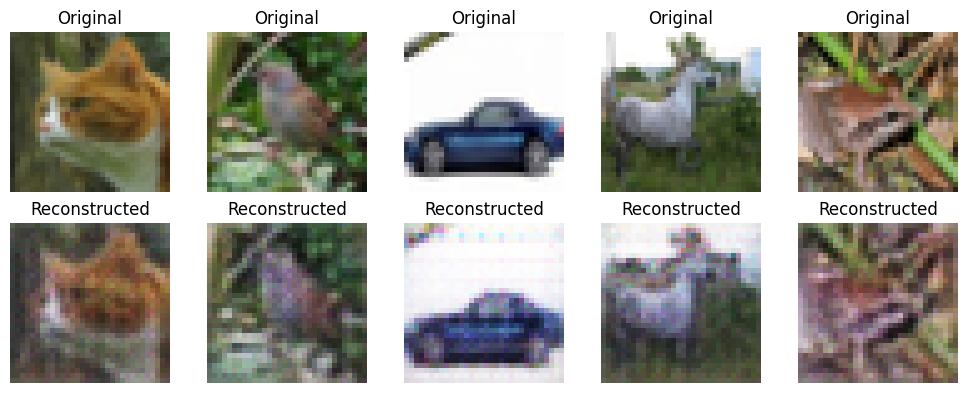

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  26/ 30  Batch:    1  Total Loss:  613.751  VQ Loss:  1.85425  Recon Loss:  611.897  Commitment Loss:  1.68568  Embedding Loss:  1.68568  LR:  1.4358e-06
Epoch:  26/ 30  Batch:  151  Total Loss:  580.65  VQ Loss:  1.82887  Recon Loss:  578.821  Commitment Loss:  1.66261  Embedding Loss:  1.66261  LR:  1.4358e-06
Epoch:  26/ 30  Batch:  301  Total Loss:  662.446  VQ Loss:  1.79452  Recon Loss:  660.652  Commitment Loss:  1.63138  Embedding Loss:  1.63138  LR:  1.4358e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      26 │          1607.12 │ 7.14s  │
╘═════════╧══════════════════╧════════╛


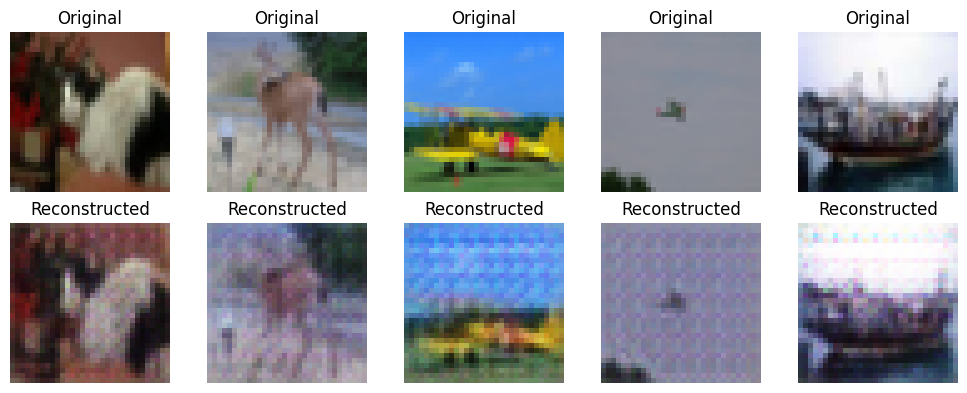

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  27/ 30  Batch:    1  Total Loss:  609.948  VQ Loss:  1.8548  Recon Loss:  608.093  Commitment Loss:  1.68618  Embedding Loss:  1.68618  LR:  1.29222e-06
Epoch:  27/ 30  Batch:  151  Total Loss:  581.462  VQ Loss:  1.80261  Recon Loss:  579.66  Commitment Loss:  1.63873  Embedding Loss:  1.63873  LR:  1.29222e-06
Epoch:  27/ 30  Batch:  301  Total Loss:  564.979  VQ Loss:  1.83105  Recon Loss:  563.148  Commitment Loss:  1.66459  Embedding Loss:  1.66459  LR:  1.29222e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      27 │          1606.03 │ 7.23s  │
╘═════════╧══════════════════╧════════╛


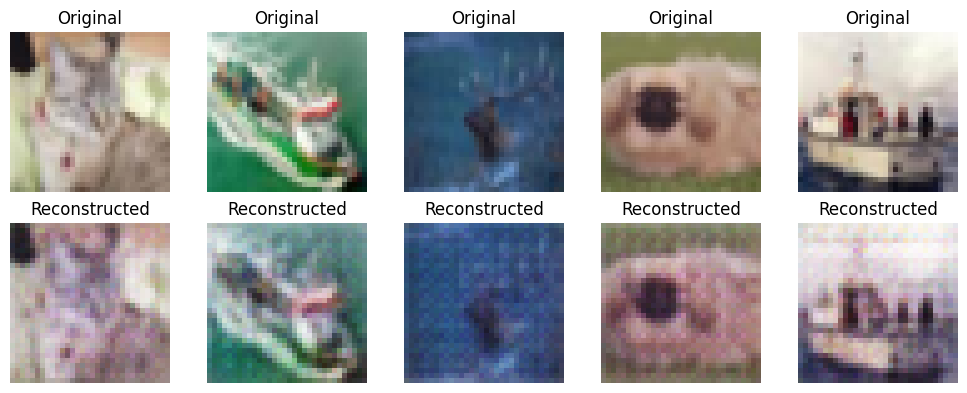

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  28/ 30  Batch:    1  Total Loss:  515.872  VQ Loss:  1.82184  Recon Loss:  514.05  Commitment Loss:  1.65622  Embedding Loss:  1.65622  LR:  1.16299e-06
Epoch:  28/ 30  Batch:  151  Total Loss:  604.256  VQ Loss:  1.80112  Recon Loss:  602.455  Commitment Loss:  1.63738  Embedding Loss:  1.63738  LR:  1.16299e-06
Epoch:  28/ 30  Batch:  301  Total Loss:  575.196  VQ Loss:  1.81367  Recon Loss:  573.382  Commitment Loss:  1.64879  Embedding Loss:  1.64879  LR:  1.16299e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      28 │          1655.38 │ 7.08s  │
╘═════════╧══════════════════╧════════╛


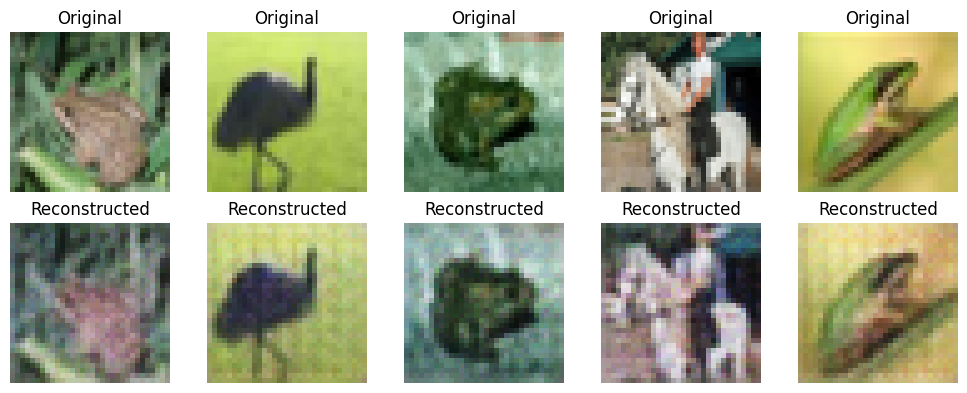

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  29/ 30  Batch:    1  Total Loss:  545.267  VQ Loss:  1.83522  Recon Loss:  543.432  Commitment Loss:  1.66838  Embedding Loss:  1.66838  LR:  1.0467e-06
Epoch:  29/ 30  Batch:  151  Total Loss:  564.424  VQ Loss:  1.84335  Recon Loss:  562.58  Commitment Loss:  1.67577  Embedding Loss:  1.67577  LR:  1.0467e-06
Epoch:  29/ 30  Batch:  301  Total Loss:  499.406  VQ Loss:  1.82651  Recon Loss:  497.579  Commitment Loss:  1.66047  Embedding Loss:  1.66047  LR:  1.0467e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      29 │          1594.94 │ 7.20s  │
╘═════════╧══════════════════╧════════╛


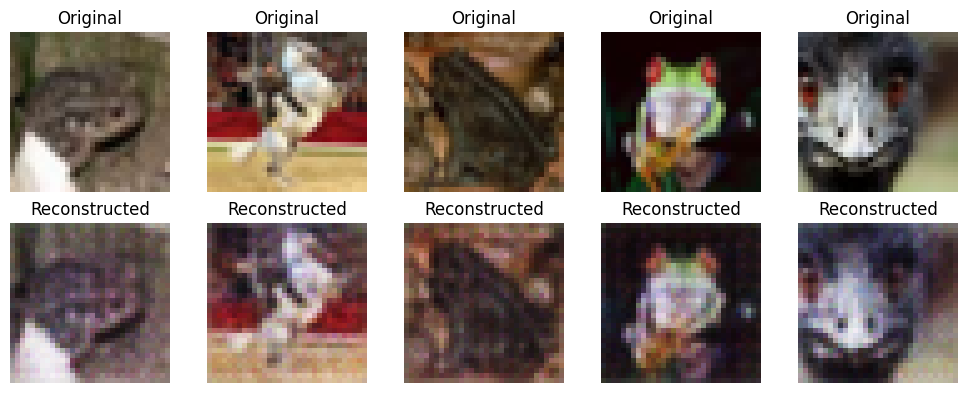

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  30/ 30  Batch:    1  Total Loss:  499.005  VQ Loss:  1.81385  Recon Loss:  497.191  Commitment Loss:  1.64895  Embedding Loss:  1.64895  LR:  9.42026e-07
Epoch:  30/ 30  Batch:  151  Total Loss:  518.746  VQ Loss:  1.83212  Recon Loss:  516.914  Commitment Loss:  1.66556  Embedding Loss:  1.66556  LR:  9.42026e-07
Epoch:  30/ 30  Batch:  301  Total Loss:  760.539  VQ Loss:  1.83427  Recon Loss:  758.704  Commitment Loss:  1.66752  Embedding Loss:  1.66752  LR:  9.42026e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      30 │          1675.74 │ 6.90s  │
╘═════════╧══════════════════╧════════╛


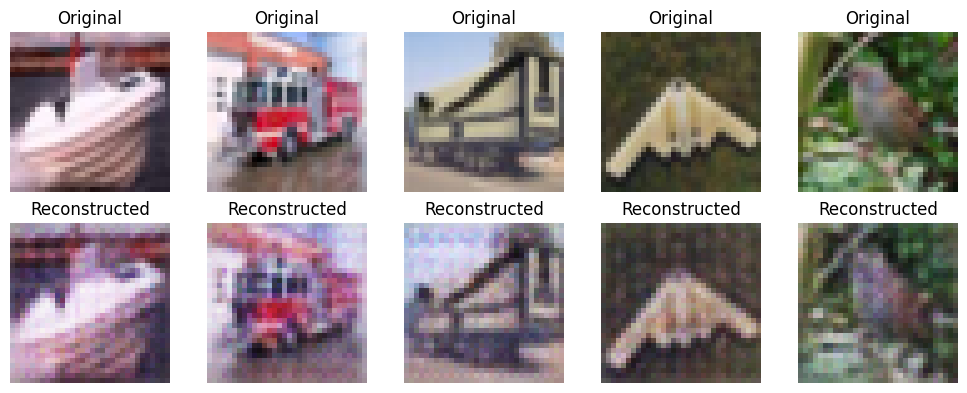

-----------------------------------------------------------------------------------------------------------------------------


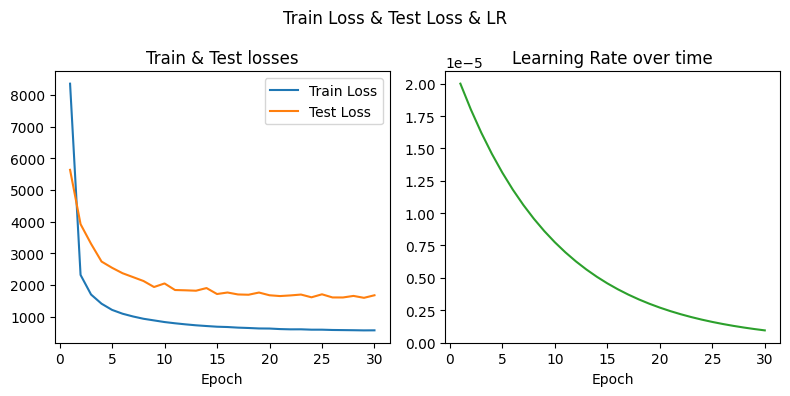

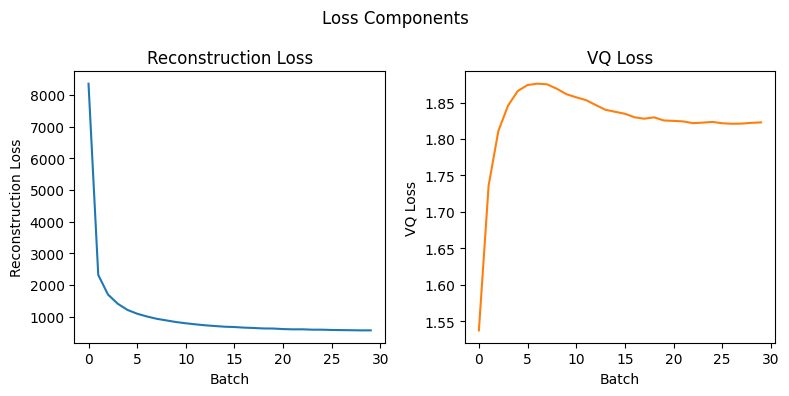

In [6]:
# Suppress user warnings
warnings.filterwarnings("ignore")

# Initialize lists for tracking losses and learning rates
train_losses = []
test_losses = []
learning_rates = []
reconstruction_losses = []
vq_losses = []
commitment_losses = []
embedding_losses = []

# Training loop
for epoch in range(num_epochs):
    print('-----------------------------------------------------------------------------------------------------------------------------')
    model.train()

    batch_recon_losses = []
    batch_vq_losses = []
    batch_total_losses = []

    epoch_start_time = time.time()  # Start of time measurement

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            # Forward pass
            recon_batch, vqloss, embedding_loss, commitment_loss = model(data)

            # Compute loss
            loss, recon_loss, _  = loss_function(recon_batch, data, vqloss)

        # Backward pass
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        # Save the loss values for the current batch
        curr_loss = loss.detach().item()
        curr_vqloss = vqloss.detach().item()
        curr_recon_loss = recon_loss.detach().item()
        curr_commitment_loss = commitment_loss.detach().item()
        curr_embedding_loss = embedding_loss.detach().item()
        batch_total_losses.append(curr_loss)
        batch_vq_losses.append(curr_vqloss)
        batch_recon_losses.append(curr_recon_loss)

        # Log training loss and current learning rate
        if batch_idx % output_frequency == 0:
            log = [['Epoch:', f'{epoch + 1:3d}/{num_epochs:3d}', 'Batch:', f'{batch_idx + 1:3d}',
                    'Total Loss:', f'{curr_loss:.6f}', 'VQ Loss:', f'{curr_vqloss:.6f}',
                    'Recon Loss:', f'{curr_recon_loss:.6f}',
                    'Commitment Loss:', f'{curr_commitment_loss:.6f}',
                    'Embedding Loss:', f'{curr_embedding_loss:.6f}',
                    'LR:', scheduler.get_last_lr()[0]]]
            print(tabulate(log, tablefmt="plain"))

    # Step the learning rate scheduler
    if scheduler is not None:
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
    else:
        lr = learning_rate
    learning_rates.append(lr)

    # After the epoch, evaluate the accuracy on the test dataset
    mean_loss = evaluate(model, test_loader, loss_function, device)
    test_losses.append(mean_loss)

    # Save the average loss values
    average_total_loss = torch.tensor(batch_total_losses).mean().item()
    average_recon_loss = torch.tensor(batch_recon_losses).mean().item()
    average_vq_loss = torch.tensor(batch_vq_losses).mean().item()

    train_losses.append(average_total_loss)
    reconstruction_losses.append(average_recon_loss)
    vq_losses.append(average_vq_loss)

    # End of time measurement
    elapsed_time = time.time() - epoch_start_time

    # Log epoch results
    headers = ["Epoch", "Mean Test Loss", "Time"]
    data = [[epoch + 1, f"{mean_loss:.4f}", f"{elapsed_time:.2f}s"]]
    print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

    # Generate reconstructed test images after each epoch
    plot_reconstruction(model, test_loader, device, num_samples=5)
    print('-----------------------------------------------------------------------------------------------------------------------------')

# Plot Train Loss & Test Loss & LR
plot_loss_lr(num_epochs, train_losses, test_losses, learning_rates)

# Plot each loss component
plot_loss_components(reconstruction_losses, vq_losses)

## Vector interpolation

In [8]:
# Create a video  of images that show the interpolation on a linear trajectory between z1 and z2
images, _ = next(iter(test_loader))
z1 = model.vectorquantizer(model.encoder(random.choice(images).to(device).unsqueeze(0)))[0]
z2 = model.vectorquantizer(model.encoder(random.choice(images).to(device).unsqueeze(0)))[0]
interpolate(z1, z2, model, steps=200, file_format='gif')

Interpolation GIF saved as output/interpolation.gif.
